In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plotly.express as px
import re
import seaborn as sns
import warnings
import lightgbm as lgbm

from category_encoders import OneHotEncoder, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import make_pipeline, Pipeline

warnings.filterwarnings(action='ignore')

#abcd efg hijk lmn opqr stu vwxyz

In [2]:
df = pd.read_csv('./data/movie_train.csv')
df.head(3)

,imdbID,Title,Year,Genre,Director,Language,Country,Poster,imdbRating,BoxOffice
0,tt0237572,The Pledge,2001,"Crime, Drama, Mystery",Sean Penn,English,"United States, Canada",https://m.media-amazon.com/images/M/MV5BNTJjNT...,6.8,"$19,733,089"
1,tt0237865,Twilight: Los Angeles,2000,Drama,Marc Levin,English,United States,https://m.media-amazon.com/images/M/MV5BMjE5Mj...,7.6,"$10,688"
2,tt0237993,101 Reykjavík,2000,"Comedy, Romance",Baltasar Kormákur,"Icelandic, English, Spanish","Iceland, Denmark, France, Norway, Germany",https://m.media-amazon.com/images/M/MV5BMTIyNT...,6.8,"$126,404"


In [3]:
target = 'BoxOffice'

In [4]:
def preprocessing(df):
    # 결측치 제거
    df_ml = df.dropna(axis=0)
    
    # imdbID, 포스터, Title,  컬럼 드랍
    df_ml.drop(['Poster'], axis=1, inplace=True)
    df_ml.drop(['imdbID'], axis=1, inplace=True)
    df_ml.drop(['Title'], axis=1, inplace=True)
    df_ml.drop(['Language'], axis=1, inplace=True)
    df_ml.drop(['Country'], axis=1, inplace=True)
    df_ml.drop(['Director'], axis=1, inplace=True)
    df_ml.drop(['Genre'], axis=1, inplace=True)
    
    # BoxOffice 컬럼 단위 제거 및 int형으로 변경
    df_ml['BoxOffice'] = df_ml['BoxOffice'].str.replace(r"[^0-9]", r"", regex=True)
    df_ml['BoxOffice'] = df_ml['BoxOffice'].astype('int')
    
#     # Genre를 하나씩 분리하기 (Genre_single 컬럼 생성) 및 Genre 컬럼 삭제
#     result = df_ml['Genre'].str.replace(" ", "")
#     result = result.str.split(',')
#     result = result.apply(lambda x: pd.Series(x))
#     result = result.stack().reset_index(level=1, drop=True).to_frame('Genre_single')
#     result = result.replace(" ", "")
#     df_ml = df_ml.merge(result, left_index=True, right_index=True, how='left')
#     df_ml.drop(['Genre'], axis=1, inplace=True)
    
    
#     # 대표 감독, 언어, 국가만 넣기
#     df_ml['Director'] = df_ml['Director'].str.split(',').str.get(0)
#     df_ml['Language'] = df_ml['Language'].str.split(',').str.get(0)
#     df_ml['Country'] = df_ml['Country'].str.split(',').str.get(0)
    
#     # usa로 통일
#     df_ml['Country'] = df_ml['Country'].str.replace('United States', 'USA')
    
    return df_ml

df_ml = preprocessing(df)

In [5]:
features = df_ml.drop(columns=[target]).columns
features

Index(['Year', 'imdbRating'], dtype='object')

In [6]:
# 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df):    
    
    # 타겟값을 log1p() 변환. (정규 분포 형태로 바꾸기 위함)
#     df_target_log = np.log1p(df[target])
    
    features = df.drop(columns=[target]).columns
    
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=2)  


    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(df_ml)

In [7]:
print(X_train.shape, X_test.shape)

(3321, 2) (831, 2)


In [8]:
print(y_train.shape, y_test.shape)

(3321,) (831,)


In [9]:
import lightgbm as lgb

train_ds = lgb.Dataset(X_train, label = y_train) 
test_ds = lgb.Dataset(X_test, label = y_test)

In [10]:
params= {
    'n_estimators':100, 'learning_rate':0.1, 'max_depth':50, 'num_iterations':200
}

In [11]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3321, number of used features: 2
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 19107699.447154
[100]	valid_0's l2: 2.27146e+15


In [12]:
predict_train = model.predict(X_train)
predict_test = model.predict(X_test)

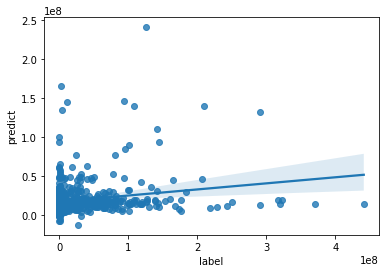

In [14]:
final_result = pd.concat([y_test.reset_index(drop=True), pd.DataFrame(predict_test)], axis = 1)
final_result.columns = ['label','predict']
sns.regplot(x = 'label', y = 'predict', data = final_result);

In [18]:
# 모델 피클링
with open('model.pkl','wb') as pickle_file:
    pickle.dump(model, pickle_file)

In [15]:
def predict_boxoffice(Year, imdbRating ):

    df = pd.DataFrame(
        data=[[Year, imdbRating]], 
        columns=['Year', 'imdbRating']
    )
    ohEncoder = OneHotEncoder()
    df_encoded = ohEncoder.fit_transform(df)

    # 예측
    pred = model.predict(df_encoded)[0]
    
    return pred


In [16]:
pred =  predict_boxoffice(Year=2001,  imdbRating=6.8)
print(pred)

9379424.021118347


In [17]:
X_train

,Year,imdbRating
4054,2008,5.4
3774,2008,6.1
2916,2006,6.6
1025,2003,6.7
3032,2005,7.4
...,...,...
3355,2007,7.8
1111,2003,6.6
2534,2007,6.2
3628,2009,5.8
